{% include toc title="On This Page" icon="file-text" %}

**Important: We are in the process of updating our lessons to use rioxarray 
which wraps around rasterio to make data processing easier. This lesson will 
be maintained for the future however we are going to start teaching rasterio 
data processing using rioxarray.**

<div class='notice--success' markdown="1">

## <i class="fa fa-graduation-cap" aria-hidden="true"></i> Learning Objectives

* Open, plot, and explore raster data using **Python**.
* Handle no data values in raster data. 
* Create plotting extents so you can plot raster and vector data together using matplotlib.
* Explore raster data using histograms and descriptive statistics.

</div>

## Open Raster Data in Open Source Python

Remember from the previous lesson that raster or “gridded” data are stored as a 
grid of values which are rendered on a map as pixels. Each pixel value 
represents an area on the Earth’s surface. A raster file is composed of 
regular grid of cells, all of which are the same size. Raster data can 
be used to store many different types of scientific data including 

* elevation data
* canopy height models
* surface temperature 
* climate model data outputs
* landuse / landcover data
* and more.

<figure>
   <a href="{{ site.url }}/images/earth-analytics/raster-data/raster-concept.png" target="_blank">
   <img src="{{ site.url }}/images/earth-analytics/raster-data/raster-concept.png" alt="Raster data concept diagram."></a>
   <figcaption>A raster is composed of a regular grid of cells. Each cell is the same
   size in the x and y direction. Source: Colin Williams, NEON.
   </figcaption>
</figure>

In this lesson you will learn more about working with lidar derived raster data
that represents both terrain / elevation data (elevation of the earth's surface),
and surface elevation (elevation at the tops of trees, buildings etc above the earth's
surface). If you want to read more about how lidar data are used to derive 
raster based surface models, you can check out <a href="https://www.earthdatascience.org/courses/use-data-open-source-python/data-stories/what-is-lidar-data/" target="_blank"> this chapter on lidar remote sensing data and the various raster data products derived from lidar data.</a> 

<figure>
   <a href="https://www.earthdatascience.org/images/earth-analytics/lidar-raster-data/lidarTree-height.png">
   <img src="https://www.earthdatascience.org/images/earth-analytics/lidar-raster-data/lidarTree-height.png" alt="Lidar derived DSM, DTM and CHM."></a>
   <figcaption>Digital Surface Model (DSM), Digital Elevation Models (DEM) and
   the Canopy Height Model (CHM) are the most common raster format lidar
   derived data products. One way to derive a CHM is to take
   the difference between the digital surface model (DSM, tops of trees, buildings
   and other objects) and the Digital Terrain Model (DTM, ground level). The CHM
   represents the actual height of trees, buildings, etc. with the influence of
   ground elevation removed. Graphic: Colin Williams, NEON
   </figcaption>
</figure>

<i class="fa fa-star"></i> **Data Tip:** 
The data used in this lesson are NEON (National Ecological Observatory Network) data. 
{: .notice--success }

To begin load the 
packages that you need to process your raster data.

In [1]:
# Import necessary packages
import os
import matplotlib.pyplot as plt
import seaborn as sns
# Use geopandas for vector data and rasterio for raster data
import geopandas as gpd
import rasterio as rio
# Plotting extent is used to plot raster & vector data together
from rasterio.plot import plotting_extent

import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="white")

In [2]:
# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 
                      'earth-analytics', 
                      'data'))

Below, you define the path to a lidar derived digital elevation model (DEM)
that was created using NEON (the National Ecological Observatory Network) data. 

<div class='notice--success alert alert-info' markdown="1">

<i class="fa fa-star"></i> **Data Tip:** DEM's are also sometimes referred to 
as DTM (Digital Terrain Model or 
DTM). You can learn more about the 3 lidar derived elevation data types: <a href="https://www.earthdatascience.org/courses/use-data-open-source-python/data-stories/what-is-lidar-data/lidar-chm-dem-dsm/" >DEMs,
Canopy Height Models (CHM) and Digital Surface Models (DSMs) in the lidar chapter
of this textbook.</a>
</div>

You then open the data using `rio.open("path-to-raster-here")`.

In [3]:
# Define relative path to file
dem_pre_path = os.path.join("colorado-flood",
                            "spatial",
                            "boulder-leehill-rd",
                            "pre-flood",
                            "lidar",
                            "pre_DTM.tif")

# Open the file using a context manager ("with rio.open" statement)
with rio.open(dem_pre_path) as dem_src:
    dtm_pre_arr = dem_src.read(1)

When you open raster data using **rasterio** you are creating a numpy array.
Numpy is an efficient way to work with and process raster format data. You can 
plot your data using earthpy `plot_bands()` which takes a 
numpy array as an input and generates a plot. 

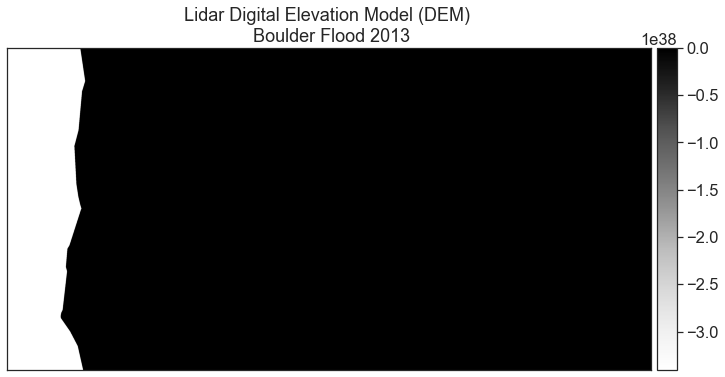

In [4]:
# Plot your data using earthpy
ep.plot_bands(dtm_pre_arr,
              title="Lidar Digital Elevation Model (DEM) \n Boulder Flood 2013",
              cmap="Greys")

plt.show()

The data above should represent terrain model data. However, the range of 
values is not what is expected. These data are for Boulder, Colorado where 
the elevation may range from 1000-3000m. 

There may be some outlier values in the data that may need to be addressed. 
Below you check out the min and max values of the data. 


In [5]:
print("the minimum raster value is: ", dtm_pre_arr.min())
print("the maximum raster value is: ", dtm_pre_arr.max())

the minimum raster value is:  -3.4028235e+38
the maximum raster value is:  2087.43


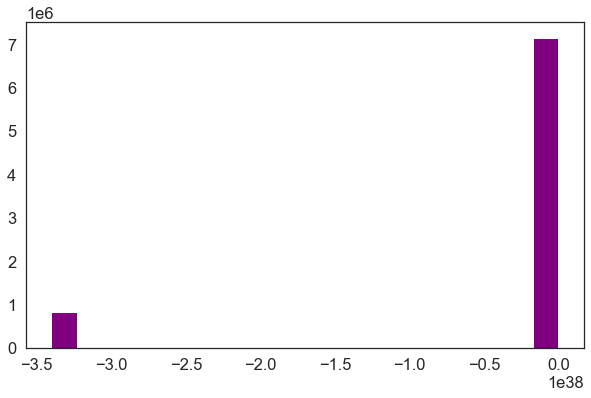

In [6]:
# A histogram can also be helpful to look at the range of values in your data
# What do you notice about the histogram below?
ep.hist(dtm_pre_arr,
        figsize=(10, 6))
plt.show()

## Raster Data Exploration - Min and Max Values

Looking at the minimum value of the data, there is one of two things going on
that need to be fixed

1. there may be no data values in the data with a negative value that are skewing your plot colors
2. there also could be outlier data in your raster

You can explore the first option - that there are no data values by reading 
in the data and masking no data values using rasterio. To do this, you will use the `masked=True` parameter for the `.read()` function - like this:

`dem_src.read(1, masked=True)`

In [7]:
# Read in your data and mask the no data values
with rio.open(dem_pre_path) as dem_src:
    # Masked=True will mask all no data values
    dtm_pre_arr = dem_src.read(1, masked=True)

Notice that now the minimum value looks more like
an elevation value (which should most often not be negative). 

In [8]:
print("the minimum raster value is: ", dtm_pre_arr.min())
print("the maximum raster value is: ", dtm_pre_arr.max())

the minimum raster value is:  1676.21
the maximum raster value is:  2087.43


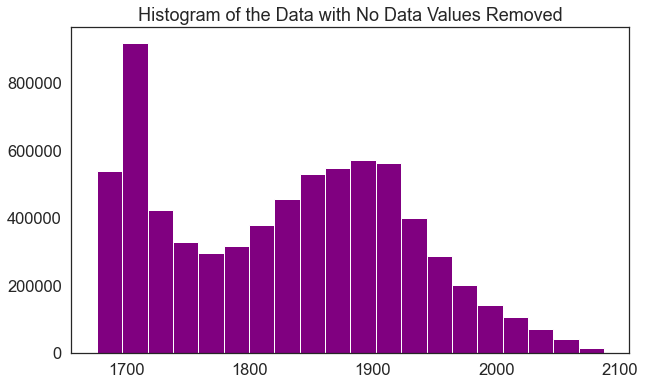

In [9]:
# A histogram can also be helpful to look at the range of values in your data
ep.hist(dtm_pre_arr,
        figsize=(10, 6),
        title="Histogram of the Data with No Data Values Removed")
plt.show()

Plot your data again to see how it looks. 

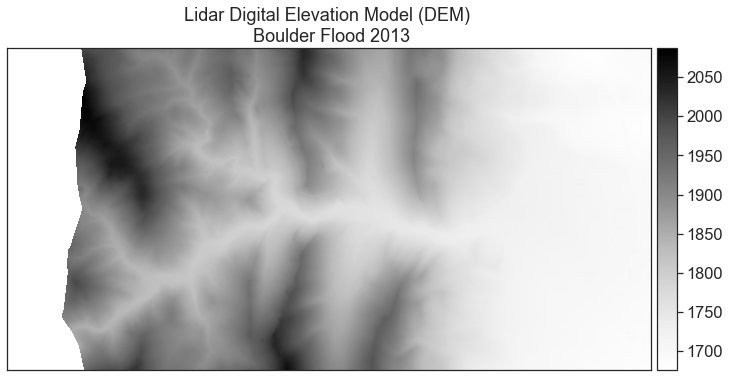

In [10]:
# Plot data using earthpy
ep.plot_bands(dtm_pre_arr,
              title="Lidar Digital Elevation Model (DEM) \n Boulder Flood 2013",
              cmap="Greys")

plt.show()

## Rasterio Reads Files into Python as Numpy Arrays

When you call `src.read()` above, rasterio is reading in the data as a 
**numpy array**. A **numpy array** is a matrix of values. **Numpy arrays** are an 
efficient structure for working with large and potentially multi-dimensional (layered) matrices.

The numpy array below is type `numpy.ma.core.MaskedArray`. It is a masked
array because you chose to mask the no data values in your data. Masking
ensures that when you plot and perform other math operations on your data, 
those no data values are not included in the operations. 

<i fa fa-star></i>**Data Tip:** <a href="https://www.earthdatascience.org/courses/intro-to-earth-data-science/scientific-data-structures-python/numpy-arrays/" target="_blank">If you want to learn more about Numpy arrays, check out the intro to earth 
datascience textbook chapter on Numpy arrays. </a>
{: .notice--success }

In [11]:
with rio.open(dem_pre_path) as dem_src:
    lidar_dem_im = dem_src.read(1, masked=True)

print("Numpy Array Shape:", lidar_dem_im.shape)
print("Object type:", type(lidar_dem_im))

Numpy Array Shape: (2000, 4000)
Object type: <class 'numpy.ma.core.MaskedArray'>


A numpy array does not by default store spatial information. However, your 
raster data is spatial - it represents a location on the earth's surface. 

You can acccess the spatial metadata within the context manager using 
`dem_src.profile`. Notice that the `.profile` object contains information including
the no data values for your data, the shape, the file type and even the coordinate 
reference system. You will learn more about 
<a href="https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/raster-metadata-in-python/" target="_blank">raster metadata in the raster metadata lesson in this chapter.</a>


In [12]:
with rio.open(dem_pre_path) as dem_src:
    lidar_dem_im = dem_src.read(1, masked=True)
    # Create an object called lidar_dem_meta that contains the spatial metadata
    lidar_dem_meta = dem_src.profile

lidar_dem_meta

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 4000, 'height': 2000, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(1.0, 0.0, 472000.0,
       0.0, -1.0, 4436000.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

## Context Managers to Open and Close File Connections

The steps above represent the steps you need to open and plot a raster 
dataset using rasterio in python. The `with rio.open()` statement creates
what is known as a context manager. A context manager allows you to open 
the data and work with it. Within the context manager, Python makes 
a temporary connection to the file that you are trying to open. 

In the example above this was a file called `pre_DTM.tif`.

To break this code down, the context manager has a few parts. 
First, it has a `with` statement. The `with` statement creates 
a connection to the file that you want to open. The default connection
type is read only. This means that you can NOT modify that file
by default. Not being able to modify the original data is a good thing
because it prevents you from making unintended changes to your 
original data.

```
with rio.open(`file-path-here`) as file_src:
   dtm_pre_arr = dem_src.read(1, masked=True)
```

Notice that the first line of the context manager is not indented.
It contains two parts

1. `rio.open()`: This is the code that will open a connection to your .tif file using a path you provide. 
2. `file_src`: this is a rasterio reader object that you can use to read in the actual data. You can also use this object to access the metadata for the raster file.

The second line of your with statement 

  `dtm_pre_arr = dem_src.read(1, masked=True)`

is indented. Any code that is indented
directly below the with statement will become a part of the context manager.
This code has direct access to the `file_src` object which is you recall above is
the rasterio reader object.

Opening and closing files using rasterio and context managers is efficient as it establishes a connection to the raster file rather than directly reading it into memory. 

Once you are done opening and reading in the data, the context manager closes
that connection to the file. This efficiently ensures that the file won't be modified 
later in your code. 



<div class='notice--success alert alert-info' markdown="1">

<i class="fa fa-star"></i> **Data Tip:**  You can open and close files without 
a context manager using the syntax below. This approach however is generally
not recommended. 

```
lidar_dem = rio.open(dem_pre_path)
lidar_dem.close()
```
</div>



You can get a better understanding of how the rasterio context manager works by taking a look at what it is doing line by line. Start by looking at the `dem_pre_path` object.
Notice that this object is a path to the file `pre_DEM.tif`. The context manager needs 
to know where the file is that you want to open with **Rasterio**.

In [13]:
# Look at the path to your dem_pre file
dem_pre_path

'colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif'

Now use the `dem_pre_path` in the context manager to open and close your connection
to the file. Notice that if you print the "`src`" object within the 
context manager (notice that the print statement is indented which is how you 
know that you are inside the context manager), the returl is an 

`open DatasetReader` 

The name of the reader is the path to your file. This means there is an open
and active connection to the file. 

In [14]:
# Opening the file with the dem_pre_path
# Notice here the src object is printed and returns an "open" DatasetReader object
with rio.open(dem_pre_path) as src:
    print(src)

<open DatasetReader name='colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif' mode='r'>


If you print that same `src` object outside of the context manager, 
notice that it is now a `closed datasetReader` object. It is closed
because it is being called outside of the context manager. Once
the connection is closed, you can no longer access the data. This 
is a good thing as it protects you from inadvertently modifying 
the file itself!

In [15]:
# Note that the src object is now closed because it's not within the indented
# part of the context manager above
print(src)

<closed DatasetReader name='colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif' mode='r'>


Now look at what `.read()` does. Below you use the context manager to both open the file and read it. See that the `read()` method, returns a numpy array that contains the 
raster cell values in your file.

In [16]:
# Open the file using a context manager and get the values as a numpy array with .read()
with rio.open(dem_pre_path) as dem_src:
    dtm_pre_arr = dem_src.read(1)

dtm_pre_arr

array([[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6956300e+03,  1.6954199e+03,  1.6954299e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6956000e+03,  1.6955399e+03,  1.6953600e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6953800e+03,  1.6954399e+03,  1.6953700e+03],
       ...,
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6814500e+03,  1.6813900e+03,  1.6812500e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6817200e+03,  1.6815699e+03,  1.6815599e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6818900e+03,  1.6818099e+03,  1.6817400e+03]], dtype=float32)

Because you created an object within the context manager that contains 
those raster values as a numpy array, you can now access the data values
without needing to have an open connection to your file. This ensures once 
again that you are not modifying your original file and that all 
connections to it are closed. You are now free to play with the numpy 
array and process your data!

In [17]:
# View numpy array of your data
dtm_pre_arr

array([[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6956300e+03,  1.6954199e+03,  1.6954299e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6956000e+03,  1.6955399e+03,  1.6953600e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6953800e+03,  1.6954399e+03,  1.6953700e+03],
       ...,
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6814500e+03,  1.6813900e+03,  1.6812500e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6817200e+03,  1.6815699e+03,  1.6815599e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6818900e+03,  1.6818099e+03,  1.6817400e+03]], dtype=float32)

You can use the `.profile` attribute to create an object with metadata on your raster image. The metadata object below contains information like the coordinate reference system and size of the raster image.

In [18]:
with rio.open(dem_pre_path) as dem_src:
    # Create an object called lidar_dem_meta that contains the spatial metadata
    lidar_dem_meta = dem_src.profile

lidar_dem_meta

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 4000, 'height': 2000, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(1.0, 0.0, 472000.0,
       0.0, -1.0, 4436000.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

Finally, take a look at what the `plotting_extent()` function does. Note below that when you run the `plotting_extent()` function on your `dem_pre` raster image, you get the extent of the image as an output.

In [19]:
with rio.open(dem_pre_path) as dem_src:
    # Create an object called lidar_dem_plot_ext that contains the spatial metadata
    lidar_dem_plot_ext = plotting_extent(dem_src)

# This plotting extent object will be used below to ensure your data overlay correctly
lidar_dem_plot_ext

(472000.0, 476000.0, 4434000.0, 4436000.0)

```
# this returns an error as you have closed the connection to the file. 
show(lidar_dem)
```

```
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-7-dad244dfd7d3> in <module>()
      1 # this returns an error as you have closed the connection to the file.
----> 2 show(lidar_dem)

~/anaconda3/envs/earth-analytics-python/lib/python3.6/site-packages/rasterio/plot.py in show(source, with_bounds, contour, contour_label_kws, ax, title, **kwargs)
     80     elif isinstance(source, RasterReader):
     81         if source.count == 1:
---> 82             arr = source.read(1, masked=True)
     83         else:
     84             try:

rasterio/_io.pyx in rasterio._io.RasterReader.read (rasterio/_io.c:10647)()

rasterio/_io.pyx in rasterio._io.RasterReader._read (rasterio/_io.c:15124)()

ValueError: can't read closed raster file

```

## Plot Raster and Vector Data Together: Plot Extents

Numpy arrays are an efficient way to store and process data. However, by default
they do not contain spatial information. To plot raster and vector data together 
on a map, you will need to create an extent object that defines the spatial extent
of your raster layer. This will then allow you to plot a raster and vector
data together to create a map.  

Below you open a single shapefile that contains a boundary layer that you can 
overlay on top of your raster dataset.


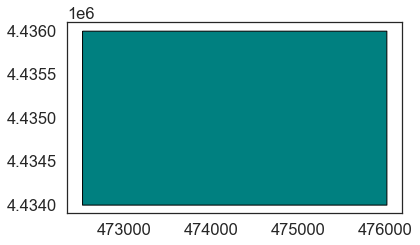

In [20]:
# Open site boundary vector layer
site_bound_path = os.path.join("colorado-flood",
                               "spatial",
                               "boulder-leehill-rd",
                               "clip-extent.shp")
site_bound_shp = gpd.read_file(site_bound_path)

# Plot the vector data
site_bound_shp.plot(color='teal',
                    edgecolor='black')
plt.show()

You can try to plot the two datasets together but you will see below that 
the output plot does not look correct. This is because the raster layer has no 
spatial information associated with it. 

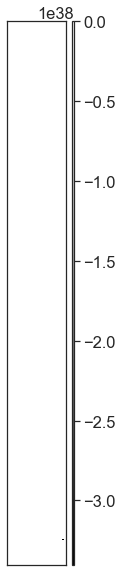

In [21]:
fig, ax = plt.subplots(figsize=(4, 10))

ep.plot_bands(dtm_pre_arr, ax=ax)

site_bound_shp.plot(color='teal',
                    edgecolor='black', ax=ax)

plt.show()

In [22]:
with rio.open(dem_pre_path) as dem_src:
    lidar_dem_im = dem_src.read(1, masked=True)
    # Create an object called lidar_dem_plot_ext that contains the spatial metadata
    lidar_dem_plot_ext = plotting_extent(dem_src)

# This plotting extent object will be used below to ensure your data overlay correctly
lidar_dem_plot_ext

(472000.0, 476000.0, 4434000.0, 4436000.0)

Next try to plot. This time however, use the `extent=` parameter
to specify the plotting extent within `ep.plot_bands()`

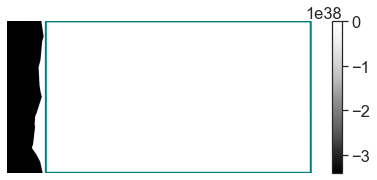

In [23]:
fig, ax = plt.subplots()

ep.plot_bands(dtm_pre_arr,
              ax=ax,
              extent=lidar_dem_plot_ext)

site_bound_shp.plot(color='None',
                    edgecolor='teal',
                    linewidth=2,
                    ax=ax)
# Turn off the outline or axis border on your plot
ax.axis('off')
plt.show()

## TODO -- make this a little customize your plot challenge

Plot again but this time you will:

1. add a colorbar legend
2. increase the title font size using the `as.set_title` function and the `fontsize` argument 

EarthPy's `plot_bands()` function adds a colorbar to your plot automatically. In the last plot, you'll notice the argument called `cbar` is set to `False`. This turns off the colorbar. The default value for the `cbar` argument is `True`. This means if you don't modify that argument, the colorbar will automatically appear! However, you may also notice a new argument in this plot, `scale=False`. By default, `plot_bands()` will scale values in a raster from 0 to 255. Since this is elevation data, you can avoid this by setting `scale=False`. 

Additionally, you will be using **matplotlib** and `earthpy.plot` together in this plot, in order to modify the title font size. `plot_bands()` can be added into any normal matplotlib plot by just giving it an axis object in the `ax=` argument. 

In [24]:
# fig, ax = plt.subplots(figsize=(12, 10))
# ep.plot_bands(lidar_dem_im,
#               cmap='Greys',
#               extent=spatial_extent,
#               scale=False,
#               ax=ax)
# ax.set_title("Lidar Digital Elevation Model \n Pre 2013 Boulder Flood | Lee Hill Road",
#              fontsize=24)
# plt.show()

<div class='notice--success alert alert-info' markdown="1">

<i class="fa fa-star"></i> **Data Tip:** Customizing Raster Plot Color Ramps
To change the color of a raster plot you set the colormap. Matplotlib has a list of  <a href="https://matplotlib.org/users/colormaps.html" target="_blank">pre-determined color ramps that you can chose from.</a> You can reverse a color ramp by adding `_r` at the end of the color ramp's name, for example `cmap = 'viridis'` vs `cmap = 'viridis_r'`. 

</div>

You now have the basic skills needed to open and plot raster data. Complete
the challenges below to test your skills. 

# TODO -- ove this to the plotting chapter?? 
## Adjust Plot Extent to "Zoom in" on Your Raster Data

If you want to quickly zoom in on a portion of your raster data, you can adjust the x and y 
spatial extents of your matplotlib plot. To do this, you will create a new spatial extent that is smaller than the 
original spatial extent of the data. 


In [25]:
# Define a spatial extent that is "smaller"
# minx, miny, maxx, maxy, ccw=True
zoomed_extent = [472500, 4434000, 473030, 4435030]

Next you'll define a box which you'll focus on. You've provided a small helper function that lets you give the x and y limits of a box, and it returns the `x,y` points corresponding to four corners of this box. It then returns a `shapely` polygon object.

In [26]:
# # Turn extent into geodataframe
# zoom_ext_gdf = gpd.GeoDataFrame()
# zoom_ext_gdf.loc[0, 'geometry'] = box(*zoomed_extent)

In [27]:
# # Plot the original data with the boundary box
# fig, ax = plt.subplots(figsize=(8, 3))

# ep.plot_bands(lidar_dem_im,
#               extent=spatial_extent,
#               title="Lidar Raster Full Spatial Extent w Zoom Box Overlayed",
#               ax=ax,
#               scale=False)

# zoom_ext_gdf.plot(ax=ax)

# ax.set_axis_off()

In [28]:
# # Plot the data but set the x and y lim
# fig, ax = plt.subplots(figsize=(8, 3))

# ep.plot_bands(lidar_dem_im,
#               extent=spatial_extent,
#               title="Lidar Raster Zoomed on a Smaller Spatial Extent",
#               ax=ax,
#               scale=False)

# # Set x and y limits of the plot
# ax.set_xlim(zoomed_extent[0], zoomed_extent[2])
# ax.set_ylim(zoomed_extent[1], zoomed_extent[3])

# ax.set_axis_off()
# plt.show()